step 1 :- prepare the dataset

In [1]:
import pandas as pd
import numpy as np 
import altair as alt #for making clear visual graphs
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


In [ ]:
import cohere 
import os
# Load API key from environment variable
api_key = os.getenv('COHERE_API_KEY', 'your-api-key-here')
co = cohere.ClientV2(api_key)

In [3]:
# load the dataset to a dataframe 
df_orig = pd.read_csv('https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/data/atis_intents_train.csv',names = ['intent','query'])

#take a small sample for illustration purposes 
sample_classes = ['atis_airfare','atis_airline','atis_ground_service']
df = df_orig.sample(frac = 0.1,random_state=30)
df = df[df.intent.isin(sample_classes)]
df_orig = df_orig.drop(df.index)
df.reset_index(drop=True,inplace = True)

#remove unnecessary column 
intents = df['intent']#save for a later need
df.drop(columns = ['intent'],inplace = True)


step2:-turn the text into emmbeddings
Next, we embed each inquiry by calling Cohere’s Embed endpoint with co.embed(). It takes in texts as input and returns embeddings as output. We supply three parameters:

texts: The list of texts you want to embed
model: The model to use to generate the embedding.
input_type — Specifies the type of document to be embedded. At the time of writing, there are four options:
search_document: For documents against which search is performed
search_query: For query documents
classification: For when the embeddings will be used as an input to a text classifier
clustering: For when you want to cluster the embeddings

In [4]:
def get_embeddings(texts,model = "embed-v4.0",input_type = "search_document"):
    output = co.embed(
        texts = texts,
        model = model,
        input_type = input_type,
        embedding_types = ["float"]
    )
    return output.embeddings.float_
df['query_embeds']=get_embeddings(df['query'].tolist())

step3:visualize embeddigns with a heatmap

In [6]:
# function to return the principal components
def get_pc(arr, n):
    pca=PCA(n_components = n)
    embeds_transform = pca.fit_transform(arr)
    return embeds_transform
# reduce the embeddings to 10 principal components to aid visuals 
embeds = np.array(df['query_embeds'].tolist())
embeds_pc = get_pc(embeds, 10)

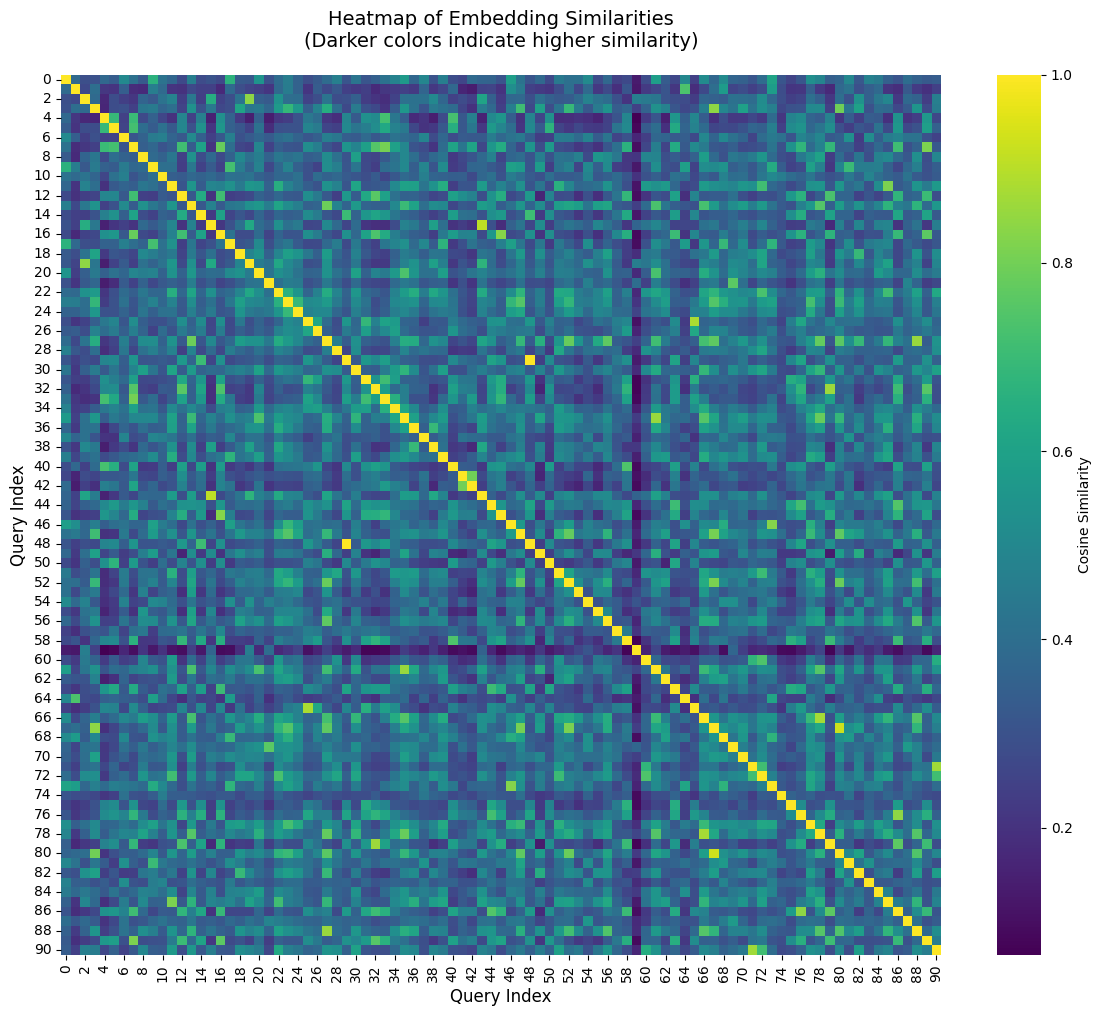

Similarity matrix shape: (91, 91)
Average similarity: 0.402
Max similarity (excluding diagonal): 1.000
Min similarity: 0.065


In [7]:
# Create heatmap visualization of embedding similarities
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(embeds)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, 
            cmap='viridis', 
            annot=False, 
            square=True,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Heatmap of Embedding Similarities\n(Darker colors indicate higher similarity)', 
          fontsize=14, pad=20)
plt.xlabel('Query Index', fontsize=12)
plt.ylabel('Query Index', fontsize=12)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Average similarity: {similarity_matrix.mean():.3f}")
print(f"Max similarity (excluding diagonal): {similarity_matrix[similarity_matrix < 1].max():.3f}")
print(f"Min similarity: {similarity_matrix.min():.3f}")

step 4 : visualize the embeddings on a 2d plot
we can investigate this further by compressing the embeddings to two dimensions and plotting them on a scatter plot . what we would except is that text of similar meaning would be closer to each other , and vice versa.

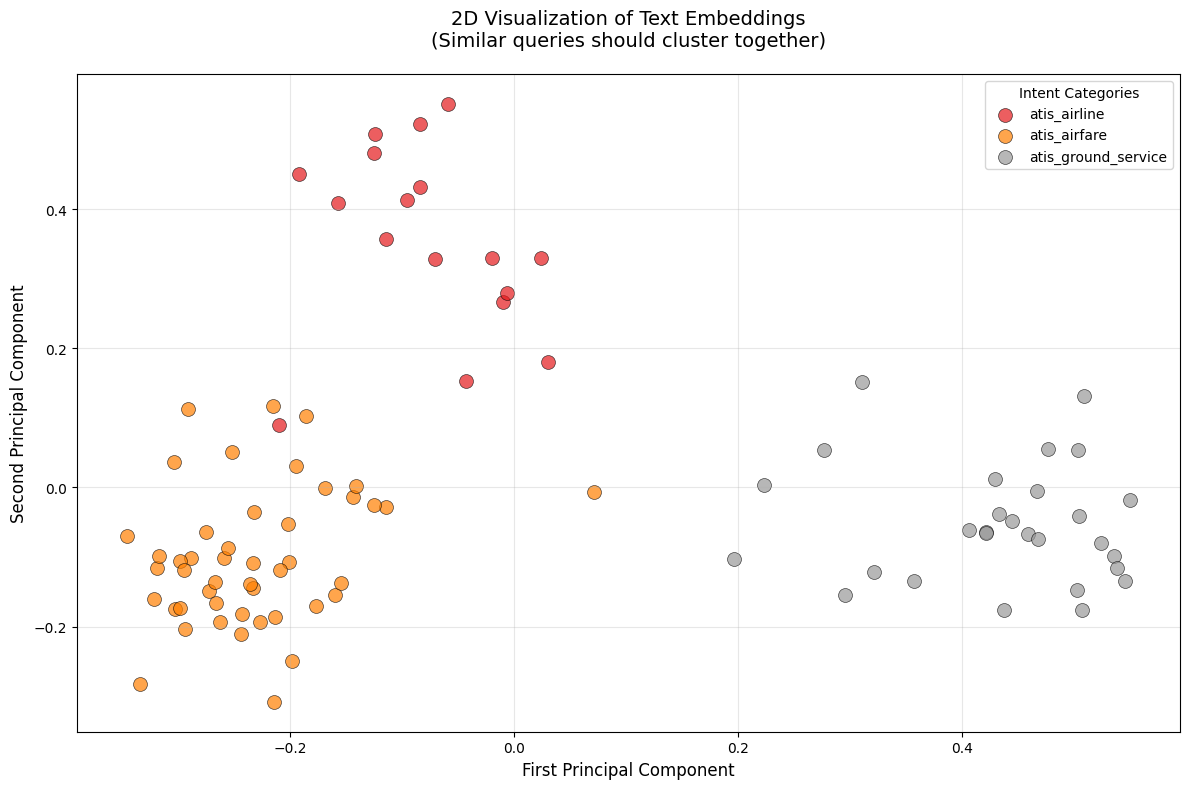

Queries by intent category:

atis_airline:
  1.  which airlines fly from boston to washington dc via other cities
  2.  show me the airlines that fly between toronto and denver
  3.  of all airlines which airline has the most arrivals in atlanta
  4.  which airlines fly between boston and pittsburgh
  5.  show me the airlines
  ... and 12 more

atis_airfare:
  1.  show me round trip first class tickets from new york to miami
  2.  i'd like the lowest fare from denver to pittsburgh
  3.  i would like your rates between atlanta and boston on september third
  4.  how much is a first class ticket from baltimore to san francisco
  5.  what's the lowest round trip fare from atlanta to bwi
  ... and 41 more

atis_ground_service:
  1.  show me a list of ground transportation at boston airport
  2.  show me boston ground transportation
  3.  what ground transportation is available in boston
  4.  what kind of ground transportation is available in las vegas
  5.  tell me about ground transporta

In [8]:
# Create 2D visualization of embeddings
# Reduce embeddings to 2D using PCA
embeds_2d = get_pc(embeds, 2)

# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({
    'x': embeds_2d[:, 0],
    'y': embeds_2d[:, 1],
    'intent': intents,
    'query': df['query']
})

# Create the scatter plot using matplotlib and seaborn
plt.figure(figsize=(12, 8))

# Create a color palette for the different intents
unique_intents = plot_df['intent'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_intents)))
color_map = dict(zip(unique_intents, colors))

# Plot each intent category with different colors
for intent in unique_intents:
    intent_data = plot_df[plot_df['intent'] == intent]
    plt.scatter(intent_data['x'], intent_data['y'], 
               c=[color_map[intent]], 
               label=intent, 
               alpha=0.7, 
               s=100,
               edgecolors='black',
               linewidth=0.5)

plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('2D Visualization of Text Embeddings\n(Similar queries should cluster together)', 
          fontsize=14, pad=20)
plt.legend(title='Intent Categories', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print cluster information
print("Queries by intent category:")
for intent in unique_intents:
    intent_queries = plot_df[plot_df['intent'] == intent]['query'].tolist()
    print(f"\n{intent}:")
    for i, query in enumerate(intent_queries[:5]):  # Show first 5 queries
        print(f"  {i+1}. {query}")
    if len(intent_queries) > 5:
        print(f"  ... and {len(intent_queries) - 5} more")

In [9]:
# Alternative visualization using Altair (interactive)
import altair as alt

# Create interactive scatter plot with Altair
chart = alt.Chart(plot_df).mark_circle(size=100, opacity=0.7).add_selection(
    alt.selection_single()
).encode(
    x=alt.X('x:Q', title='First Principal Component'),
    y=alt.Y('y:Q', title='Second Principal Component'),
    color=alt.Color('intent:N', 
                   title='Intent Category',
                   scale=alt.Scale(scheme='category10')),
    tooltip=['query:N', 'intent:N'],
    stroke=alt.value('black'),
    strokeWidth=alt.value(1)
).properties(
    width=600,
    height=400,
    title={
        "text": ["Interactive 2D Visualization of Text Embeddings", 
                "Hover over points to see queries"],
        "fontSize": 14
    }
).resolve_scale(
    color='independent'
)

# Display the chart
chart.show()

# Calculate and display cluster statistics
print("\nCluster Analysis:")
print(f"Number of queries: {len(plot_df)}")
print(f"Number of intent categories: {len(unique_intents)}")
print(f"Embedding dimensions reduced from {embeds.shape[1]} to 2")

# Calculate average distances within and between clusters
from scipy.spatial.distance import pdist, squareform

for intent in unique_intents:
    intent_data = plot_df[plot_df['intent'] == intent]
    if len(intent_data) > 1:
        intent_points = intent_data[['x', 'y']].values
        distances = pdist(intent_points)
        avg_distance = np.mean(distances)
        print(f"Average intra-cluster distance for {intent}: {avg_distance:.3f}")
    else:
        print(f"{intent}: Only one query in this category")

C:\Users\piyus\AppData\Local\Temp\ipykernel_26520\3708619951.py:6: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  alt.selection_single()
C:\Users\piyus\AppData\Local\Temp\ipykernel_26520\3708619951.py:5: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  chart = alt.Chart(plot_df).mark_circle(size=100, opacity=0.7).add_selection(


alt.Chart(...)


Cluster Analysis:
Number of queries: 91
Number of intent categories: 3
Embedding dimensions reduced from 1536 to 2
Average intra-cluster distance for atis_airline: 0.186
Average intra-cluster distance for atis_airfare: 0.151
Average intra-cluster distance for atis_ground_service: 0.163
